In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
def get_gs(df, tm = 'Tl', jez=False):
    df['K_W_Tc'] = (df.Tc - df.Tg) / df[tm] # best one in the paper
    df['K_W_Tx'] = (df.Tx - df.Tg) / df[tm]
    df['gamma_Tc'] = df.Tc / (df.Tg+df.Tl)
    df['H_prime_Tx'] = (df.Tx - df.Tg) / df.Tg
    df['K_H_Tc'] = (df.Tc - df.Tg) / (df[tm] - df.Tc) # replaced Tmelt with Tliq
    df['H_prime_Tc'] = (df.Tc - df.Tg) / df.Tg
    df['K_H_Tx'] = (df.Tx - df.Tg) / (df[tm] - df.Tx) # replaced Tmelt with Tliq
    df['deltaT_rg'] = (df.Tx - df.Tg) / (df.Tl - df.Tg)
    df['K_cr'] = (df.Tl - df.Tx) / (df.Tl - df.Tg)
    if jez:
        df['Jezica'] = (df.ViscosityAtTl) - 2 * np.log10(df.Tl)
    return df
    
def get_eta_tl(df):
    return df['log10 (η∞)'] + (12-df['log10 (η∞)'])*(df.T12/df.Tl)*np.exp((df.m/(12-df['log10 (η∞)'])-1)*(df.T12/df.Tl - 1))
    
def get_gfa(df, logXs = -2, logNs = 3, g=pi, **kw):
    Umax = 10 ** df.log_Umax
    
    tn = (10**logXs / (g * 10**logNs * Umax**2))**(1 / 2)

    df['GFA'] = -np.log10((df.Tl - df.T_Umax) / tn)
    return df

In [3]:
os.getcwd()

'/Users/sarahisabelallec/Library/CloudStorage/Box-Box/Sarah_Personal/ZOSMA/GFA_PAPER/FINAL_FIGURES'

# Load models and data

In [4]:
glassnet_no_stnn = GlassNet(st_models=[])
glassnet_stnn = GlassNet()

In [5]:
glassnet_test_df = pd.read_csv('glassnet_test_df.csv', index_col=0, header=[0, 1])
glassnet_train_df = pd.read_csv('glassnet_train_df.csv', index_col=0, header=[0, 1])

In [6]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [7]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)
X_glassnet_feats_total, feats = glassnet_stnn.featurizer(X_glassnet_total, return_cols = True)

In [8]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)
X_glassnet_feats_total = pd.DataFrame(X_glassnet_feats_total, columns = feats)

In [9]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index
X_glassnet_feats_total.index = X_glassnet_total.index

In [10]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

# Compute true GS parameters

In [11]:
gs_glassnet_train = get_gs(y_glassnet_train )
gs_glassnet_test = get_gs( y_glassnet_test )
gs_glassnet_total = pd.concat( (gs_glassnet_train, gs_glassnet_test) )

In [12]:
gfa_glassnet_train = get_gfa(y_glassnet_train)
gfa_glassnet_test = get_gfa(y_glassnet_test)
gfa_glassnet_total = pd.concat( (gfa_glassnet_train, gfa_glassnet_test) )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Evaluate GlassNet accuracy for GS prediction for different glass families

In [13]:
formers = ['Si', 'P', 'B', 'Al']
modifiers = ['Na', 'Li', 'K', 'Cs', 'Ca', 'Mg'] # have not used yet

In [14]:
X_by_former = []
for former in formers:
    X_by_former.append( X_glassnet_total[ X_glassnet_total[former] >  X_glassnet_total[ [f for f in formers if f != former] ].sum(axis=1) ] )   

In [15]:
myrcparams = {
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

## Characteristic temperatures

In [16]:
temp_cols = ['Tg', 'Tc', 'Tx', 'Tl']
temp_titles = ['$T_g$', '$T_c$', '$T_x$', '$T_l$']
colors = ['coral', 'dodgerblue', 'mediumaquamarine', 'orchid']
ecolors = ['darkred', 'navy', 'teal', 'darkmagenta']
alphas = [0.8, 0.7, 0.6, 0.6]

In [17]:
source = SciGlass()
df = source.data
source.remove_duplicate_composition(aggregator='std')
df_std = source.data.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})
quantiles = df_std.property[temp_cols].quantile(q=0.75)

Tg Si 2152 0.9576038382414686 19.66075410031918 10.292590959029836
Tg P 1324 0.962208816721034 16.947877805038523 10.292590959029836
Tg B 1618 0.954121910790011 16.90867508548152 10.292590959029836
Tg Al 333 0.9930377007363402 12.628773456579214 10.292590959029836
Tc Si 473 0.8480723614835338 56.01105319483336 33.23401871576773
Tc P 265 0.867978603072734 42.07973484897388 33.23401871576773
Tc B 225 0.8605507674966595 41.461279792918084 33.23401871576773
Tc Al 137 0.9424427406150213 36.89473182180501 33.23401871576773
Tx Si 128 0.8286066825537124 60.50999051611871 20.506096654409877
Tx P 162 0.8702861015221339 39.09192399956561 20.506096654409877
Tx B 101 0.8754147211027965 39.439037023204364 20.506096654409877
Tx Al 147 0.9489472492145287 34.891496918639355 20.506096654409877
Tl Si 2160 0.9046302372590147 48.515202819389195 7.723145199062156
Tl P 331 0.9516738427258041 46.00256756607972 7.723145199062156
Tl B 477 0.9334590261457774 37.73287609495709 7.723145199062156
Tl Al 152 0.989968

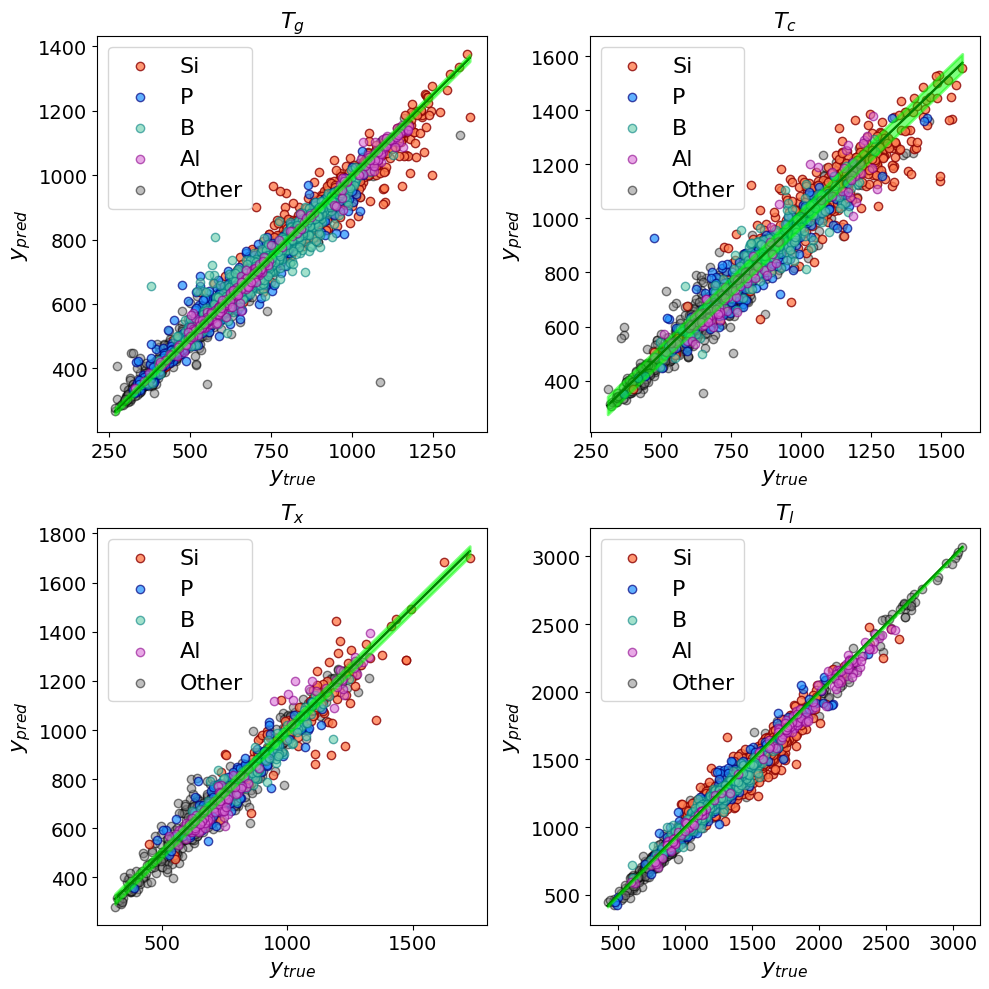

In [18]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
r2_arr = np.zeros( ( len(formers) + 1, len(temp_cols) ) )
resids_t = {col:[] for col in temp_cols}
for i, col in enumerate(temp_cols):
    
    if i < 2:
        ax = axes[0,i]
    else:
        ax = axes[1,i-2]
    y_true_all = []
    former_inds = []
    for j,former in enumerate( formers ):
        X = X_by_former[j]
        inds_test = y_glassnet_test[col].dropna().index.intersection( X.index )
        y_test = y_glassnet_test.loc[inds_test, col]
        y_gn_pred = glassnet_stnn.predict( X_glassnet_test.loc[ inds_test, : ] ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})[col]
        y_gn_pred.index = inds_test
        
        ax.scatter(y_test, y_gn_pred, color = colors[j], alpha = alphas[j], edgecolor = ecolors[j], label = former, zorder=2)
        print( col, former, len(inds_test), r2_score( y_test, y_gn_pred ), mean_absolute_error( y_test, y_gn_pred ), quantiles[col] )
        r2_arr[j,i] = r2_score( y_test, y_gn_pred )
        resids_t[col].append( y_gn_pred - y_test )
        for y in y_test:
            if y not in y_true_all:
                y_true_all.append(y)
        for ind in list( inds_test ):
            former_inds.append(ind)
    y_true_line = np.linspace(min(y_glassnet_test[col].dropna()), max(y_glassnet_test[col].dropna()), 100)
    ax.plot(y_true_line, y_true_line, color='k')
    ax.plot(y_true_line, y_true_line, color='k')
    ax.fill_between(y_true_line, (y_true_line-quantiles[col]), (y_true_line+quantiles[col]), color='lime', alpha=.5, linewidth=2.0, zorder=3 )
    
    other_inds = [ i for i in list(y_glassnet_test[col].dropna().index) if i not in former_inds ]
    others_y_pred = glassnet_stnn.predict( X_glassnet_test.loc[ other_inds, : ] ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})[col]
    others_y_pred.index = other_inds
    ax.scatter(y_glassnet_test.loc[other_inds, col].dropna(),  others_y_pred, color = 'gray', edgecolor='black', alpha = 0.5, zorder=1, label='Other')
    r2_arr[-1,i] = r2_score( y_glassnet_test.loc[other_inds, col].dropna(), others_y_pred )
    
    resids_t[col].append( others_y_pred - y_glassnet_test.loc[other_inds, col] )
    #ax.fill_between(y_true_line, (y_true_line-quantiles[col]), (y_true_line+quantiles[col]), color='yellow', alpha=.5)
    
    ax.legend()
    ax.set_title(temp_titles[i])
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$y_{pred}$')
fig.savefig('figure5.png', dpi=600)

In [19]:
r2_df = pd.DataFrame( r2_arr, columns = temp_cols )
r2_df.index = formers + ['other']

In [20]:
r2_df

,Tg,Tc,Tx,Tl
Si,0.957604,0.848072,0.828607,0.904630
P,0.962209,0.867979,0.870286,0.951674
B,0.954122,0.860551,0.875415,0.933459
Al,0.993038,0.942443,0.948947,0.989969
other,0.973384,0.934960,0.933524,0.988694


In [21]:
y_gn_pred = glassnet_stnn.predict( X_glassnet_test ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})

In [22]:
gs_gn_pred = get_gs( y_gn_pred )

In [23]:
gs_gn_pred.index = X_glassnet_test.index

In [24]:
gs_cols = ['K_W_Tc', 'gamma_Tc', 'H_prime_Tc']
gs_titles = [r'$K_{W}(T_{c})$', r'$\gamma(T_{c})$', 
          r'$H^{\prime}(T_{c})$']

In [25]:
myrcparams = {
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

K_W_Tc Si 19 0.775198773242356 0.026494320278840956
K_W_Tc P 9 -0.08881058495021699 0.037649766457730424
K_W_Tc B 31 0.03525255381807879 0.039364785675178114
K_W_Tc Al 7 0.18678136034410697 0.02133365281461776
57
gamma_Tc Si 19 0.749363446340467 0.019240585232280633
gamma_Tc P 9 0.16678851634726033 0.022469686068525705
gamma_Tc B 31 0.30777237914719335 0.024655721188022766
gamma_Tc Al 7 0.420586871084455 0.01737354416743966
57
H_prime_Tc Si 331 0.4448606060311332 0.0667197094263675
H_prime_Tc P 252 0.3292780109873058 0.06071849397257802
H_prime_Tc B 200 0.46973219497906415 0.060881893962050154
H_prime_Tc Al 120 0.1029159134180333 0.0475212426645358
801


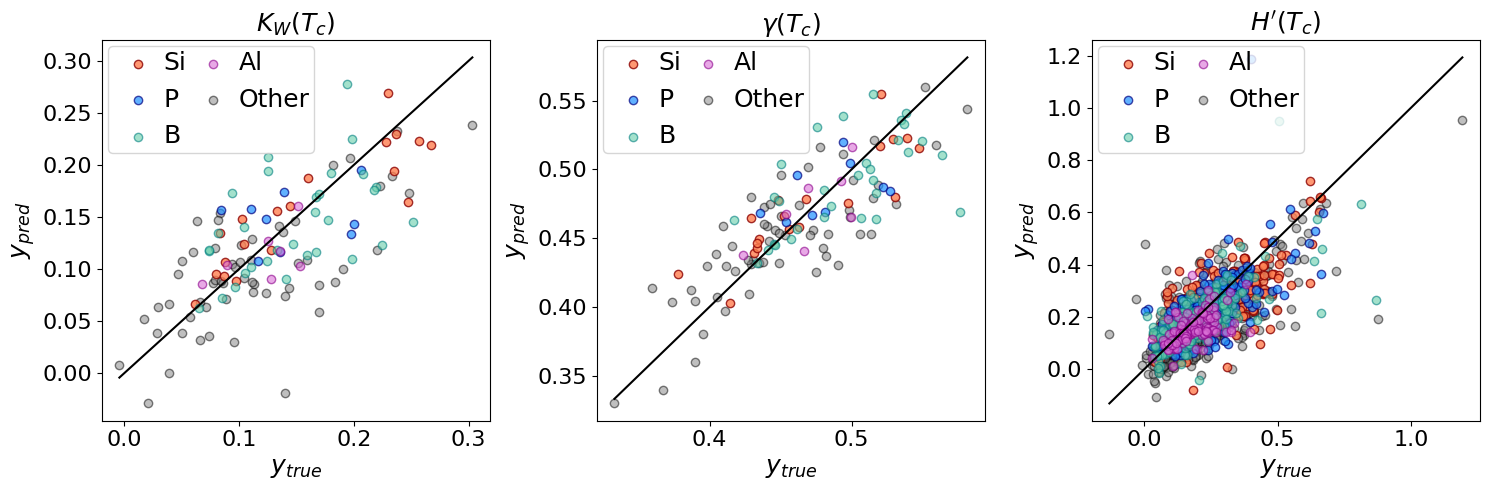

In [26]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
r2_arr = np.zeros( ( len(formers) + 1, len(gs_cols) ) )
mae_arr = np.zeros( ( len(formers) + 1, len(gs_cols) ) )
resids_gs = {col:[] for col in gs_cols}
for i, col in enumerate(gs_cols):
    
    ax = axes[i]
    y_true_all = []
    former_inds = []
    for j,former in enumerate( formers ):
        X = X_by_former[j]
        inds_test = gs_glassnet_test[col].dropna().index.intersection( X.index )
        y_test = gs_glassnet_test.loc[inds_test, col]
        y_gn_pred = gs_gn_pred.loc[inds_test, col]
        
        ax.scatter(y_test, y_gn_pred, color = colors[j], alpha = alphas[j], edgecolor = ecolors[j], label = former, zorder=2)
        print( col, former, len(inds_test), r2_score( y_test, y_gn_pred ), mean_absolute_error( y_test, y_gn_pred ) )
        r2_arr[j,i] = r2_score( y_test, y_gn_pred )
        mae_arr[j,i] = mean_absolute_error( y_test, y_gn_pred )
        resids_gs[col].append( y_gn_pred - y_test )
        for y in y_test:
            if y not in y_true_all:
                y_true_all.append(y)
        for ind in list( inds_test ):
            former_inds.append(ind)
    y_true_line = np.linspace(min(y_glassnet_test[col].dropna()), max(y_glassnet_test[col].dropna()), 100)
    ax.plot(y_true_line, y_true_line, color='k')

    
    other_inds = [ i for i in list(gs_glassnet_test[col].dropna().index) if i not in former_inds ]
    print(len(other_inds))
    others_y_pred = gs_gn_pred.loc[ other_inds, col ]
    ax.scatter(gs_glassnet_test.loc[other_inds, col].dropna(),  others_y_pred, color = 'gray', edgecolor='black', alpha = 0.5, zorder=1, label='Other')
    resids_gs[col].append( others_y_pred - gs_glassnet_test.loc[other_inds, col] )
    
    r2_arr[-1,i] = r2_score( gs_glassnet_test.loc[other_inds, col].dropna(), others_y_pred )
    mae_arr[-1,i] = mean_absolute_error( gs_glassnet_test.loc[other_inds, col].dropna(), others_y_pred )
    #ax.fill_between(y_true_line, (y_true_line-quantiles[col]), (y_true_line+quantiles[col]), color='yellow', alpha=.5)
    
    ax.legend(ncol=2, columnspacing=0.05, handletextpad = 0.025, borderpad = 0.2, borderaxespad = 0.25)
    ax.set_title(gs_titles[i])
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$y_{pred}$')
fig.savefig('figure6_1.png', dpi=600)

In [27]:
r2_df = pd.DataFrame( r2_arr, columns = gs_cols )
r2_df.index = formers + ['other']

In [28]:
r2_df

,K_W_Tc,gamma_Tc,H_prime_Tc
Si,0.775199,0.749363,0.444861
P,-0.088811,0.166789,0.329278
B,0.035253,0.307772,0.469732
Al,0.186781,0.420587,0.102916
other,0.384046,0.647263,0.439457


In [29]:
mae_df = pd.DataFrame( mae_arr, columns = gs_cols )
mae_df.index = formers + ['other']

In [30]:
mae_df

,K_W_Tc,gamma_Tc,H_prime_Tc
Si,0.026494,0.019241,0.066720
P,0.037650,0.022470,0.060718
B,0.039365,0.024656,0.060882
Al,0.021334,0.017374,0.047521
other,0.038233,0.025218,0.065253


In [31]:
from scipy.stats import kendalltau

Si Tc K_W_Tc 19 0.7894736842105262
Si Tc gamma_Tc 19 0.7777777777777777
Si Tc H_prime_Tc 331 0.7070768104000732
P Tc H_prime_Tc 252 0.6371340036678681
B Tc K_W_Tc 31 0.7161290322580647
B Tc gamma_Tc 31 0.7419354838709677
B Tc H_prime_Tc 200 0.7030150753768843
Al Tc H_prime_Tc 120 0.6929971988795517
other Tc K_W_Tc 57 0.6942355889724312
other Tc gamma_Tc 57 0.6516290726817043
other Tc H_prime_Tc 801 0.6499812734082397


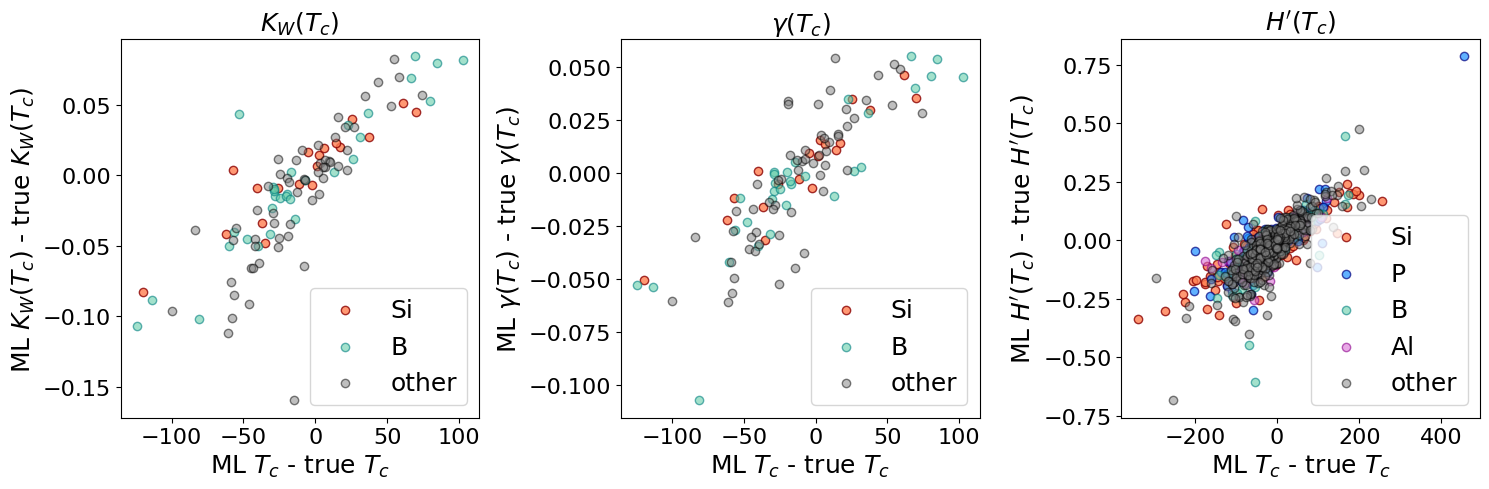

In [32]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
colors = colors + ['gray']
ecolors = ecolors + ['black']
alphas = alphas + [0.5]
for i,col in enumerate(temp_cols):

    for j,former in enumerate(formers+["other"]):
        this_resids_t = resids_t[col][j]
        
        for k, gs_col in enumerate(gs_cols):
            ax = axes[k]
            this_resids_gs = resids_gs[gs_col][j]
            inds = this_resids_t.index.intersection( this_resids_gs.index )
            tau_gs = kendalltau( this_resids_t.loc[inds], this_resids_gs.loc[inds] )

            if len(inds) > 10:
                if tau_gs[0] > 0.5 and tau_gs[1] < 0.05:
                    print(former, col, gs_col, len(inds), tau_gs[0])
                    
                    ax.scatter(this_resids_t.loc[inds], this_resids_gs.loc[inds], color = colors[j], alpha = alphas[j], 
                       edgecolor = ecolors[j], label = former)
                    #ax.legend(ncol=2, columnspacing=0.05, handletextpad = 0.025, borderpad = 0.2, borderaxespad = 0.25)
                    ax.legend()
                    ax.set_title(gs_titles[k])
                    ax.set_xlabel(f'ML {temp_titles[i]} - true {temp_titles[i]}')
                    ax.set_ylabel(f'ML {gs_titles[k]} - true {gs_titles[k]}' )
        fig.savefig('figure6_2.png')

In [33]:
y_glassnet_pred = glassnet_stnn.predict( X_glassnet_test ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})

In [34]:
y_glassnet_pred.index = y_glassnet_test.index

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
for i,col in enumerate(temp_cols):
    y_true = y_glassnet_test[col].dropna()
    y_pred = y_glassnet_pred.loc[ y_true.index, col ]

    print(col, mean_absolute_error( y_true, y_pred ), np.sqrt( mean_squared_error( y_true, y_pred ) ), quantiles[col] )

Tg 16.832642492832925 26.98560164543256 10.292590959029836
Tc 42.555135884705265 60.407471923551874 33.23401871576773
Tx 40.37482068571242 54.61877931601058 20.506096654409877
Tl 44.6880286431688 59.20951869065327 7.723145199062156
